## AI-POWERED LUNG CANCER SCREENING
### BY: MANNAHIL MIFTAH (20K-0234) & ALISHBA SUBHANI (20K-0351)

In [ ]:
import os
import time
import shutil
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
import matplotlib.pyplot as plt
from keras.models import load_model
import matplotlib.gridspec as gridspec
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, Add, AveragePooling2D, Input, ZeroPadding2D
from tensorflow.keras.layers import Activation, DepthwiseConv2D, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.metrics import Recall, Precision, AUC, RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.python.keras.callbacks import EarlyStopping
from keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception, MobileNet

## Mounting Google Drive in order to save dataset in colab environment

In [ ]:
# Mount Google Drive in order to get dataset
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the dataset from drive to colab enviornment
!cp '/content/drive/MyDrive/lungsdataset.zip' '/content/sample_data'

In [ ]:
# Unzip dataset
!unzip -q '/content/sample_data/lungsdataset.zip' -d '/content/sample_data'

## Reading dataset & saving it in dataframe

In [ ]:
# Function to read Images in dataset and storing in dataframe
def read_folder(path):

  # Paths of each image
  filepaths = []

  # labels of each image
  labels = []

  # root is the current directory path
  # dir is the list of subdirectories in root
  # files is the list of non-directory files in fir
  for root, dir, files in os.walk(path):
    for folders in dir:
      if folders in ["lung_image_sets", "colon_image_sets"]:
        continue

      classpath = os.path.join(root, folders)

      # os.listdir() is used to get the file names as strings specified in the directory
      f_name = os.listdir(classpath)

      for f in f_name:
        f_path = os.path.join(classpath, f)
        filepaths.append(f_path)
        labels.append(folders)

  Fseries = pd.Series(filepaths, name = 'filepaths')
  Lseries = pd.Series(labels, name = 'labels')
  data = pd.concat([Fseries, Lseries], axis = 1)
  data = data.reset_index(drop = True)

  return data

In [ ]:
# Reading Images
dir = r'/content/sample_data/lung_colon_image_set'

df = read_folder(dir)

In [ ]:
df

,filepaths,labels
0,/content/sample_data/lung_colon_image_set/colo...,colon_aca
1,/content/sample_data/lung_colon_image_set/colo...,colon_aca
2,/content/sample_data/lung_colon_image_set/colo...,colon_aca
3,/content/sample_data/lung_colon_image_set/colo...,colon_aca
4,/content/sample_data/lung_colon_image_set/colo...,colon_aca
...,...,...
24995,/content/sample_data/lung_colon_image_set/lung...,lung_n
24996,/content/sample_data/lung_colon_image_set/lung...,lung_n
24997,/content/sample_data/lung_colon_image_set/lung...,lung_n
24998,/content/sample_data/lung_colon_image_set/lung...,lung_n


## Exploratory Data Analysis

In [ ]:
# Distribution of classes in the dataset

unique_label, label_count = np.unique(df['labels'], return_counts = True)

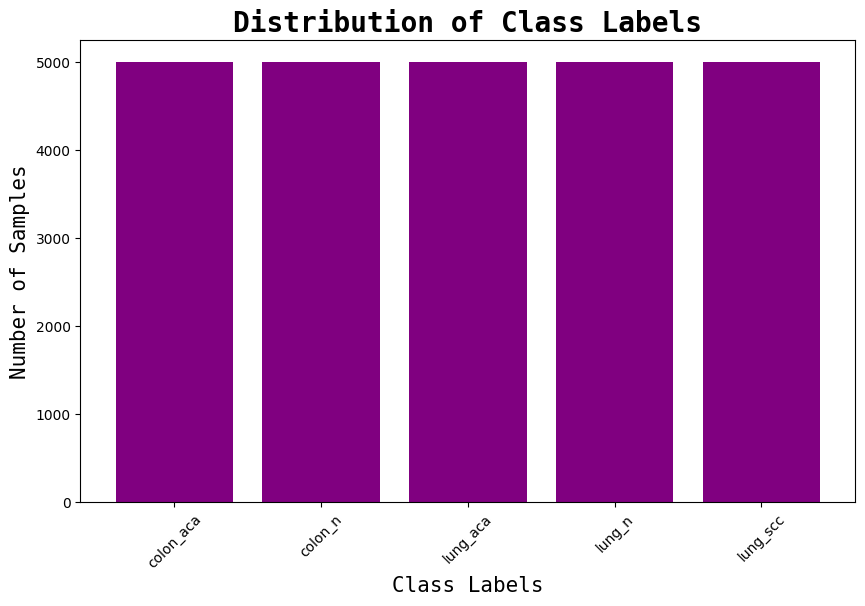

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(unique_label, label_count, color = 'purple')
plt.title('Distribution of Class Labels', fontdict={'fontname': 'Monospace', 'fontsize':20, 'fontweight': 'bold'})
plt.xlabel('Class Labels', fontdict={'fontname':'Monospace', 'fontsize': 15})
plt.ylabel('Number of Samples', fontdict={'fontname':'Monospace', 'fontsize': 15})
plt.xticks(rotation = 45)
plt.show()

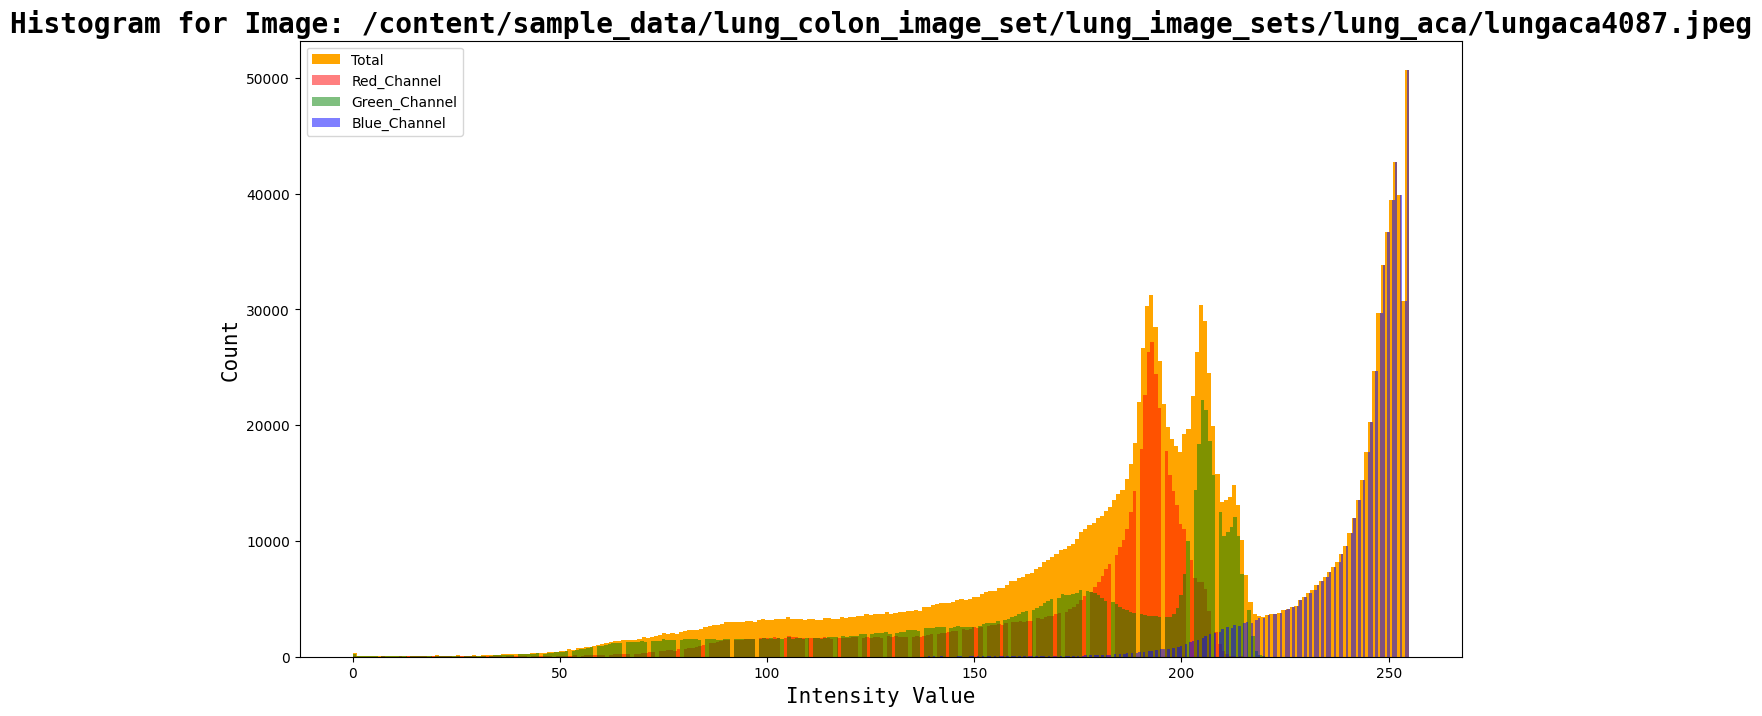

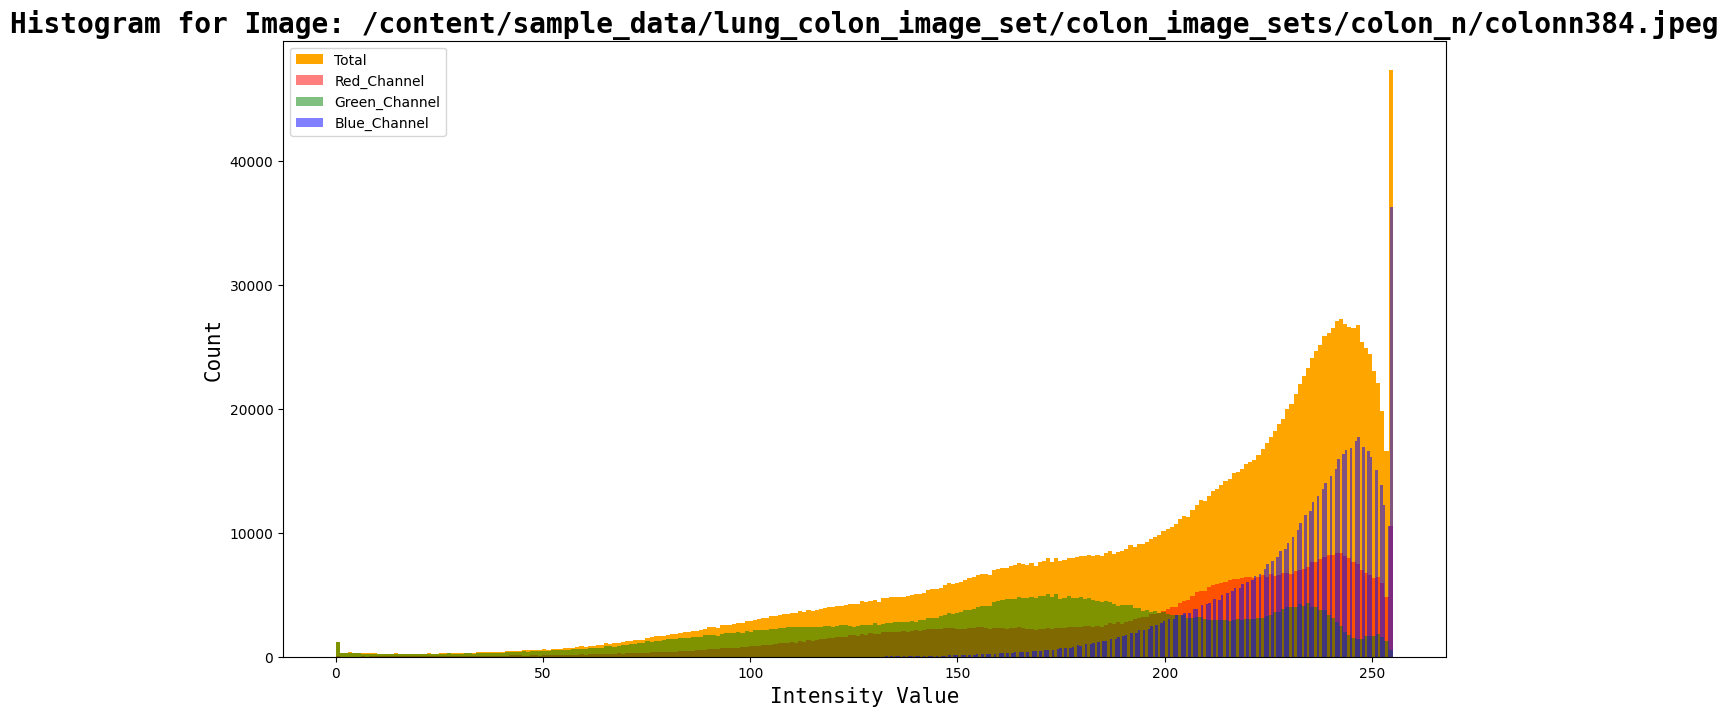

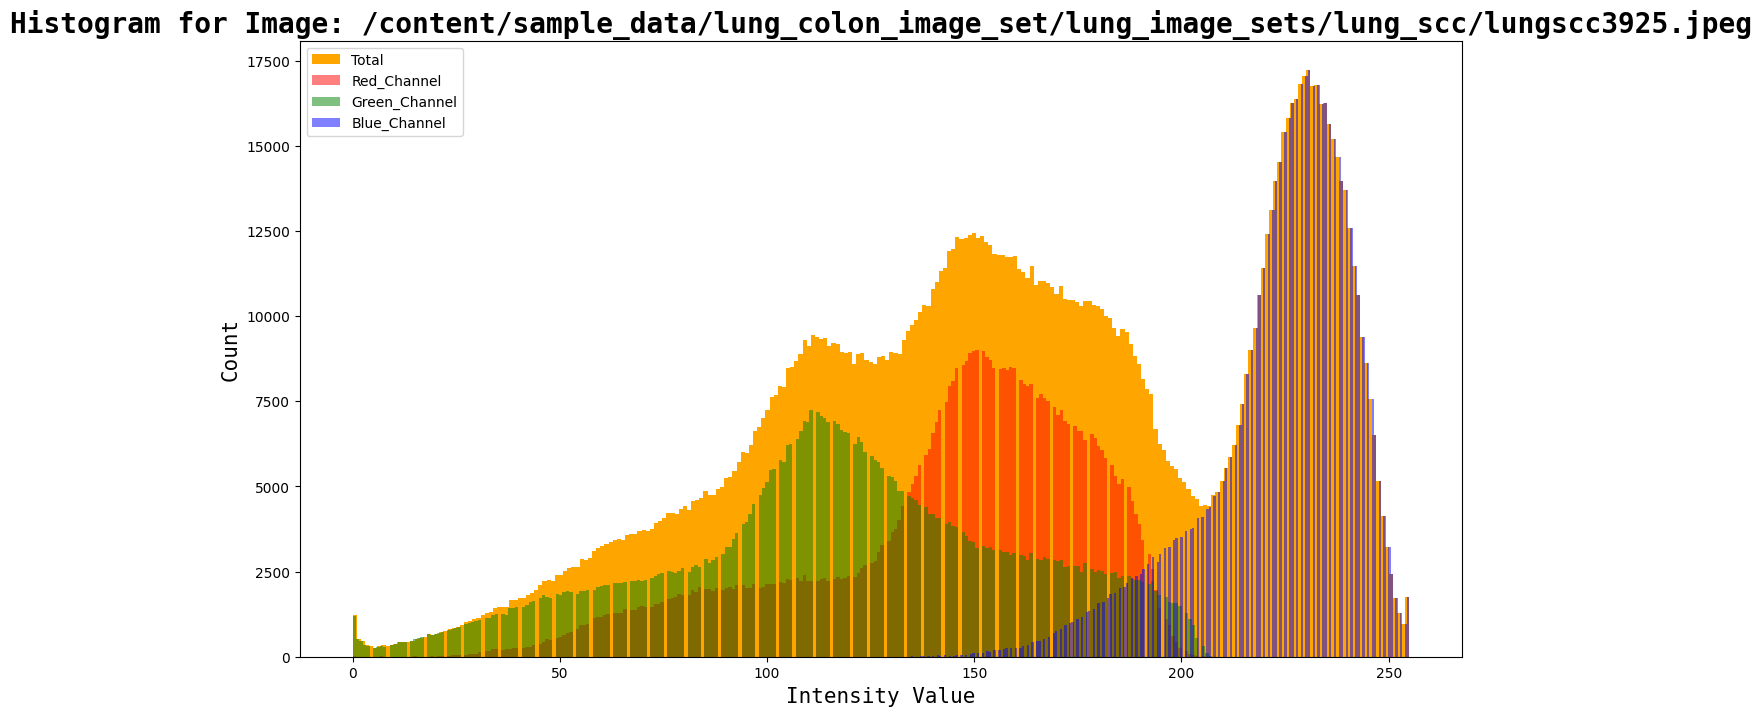

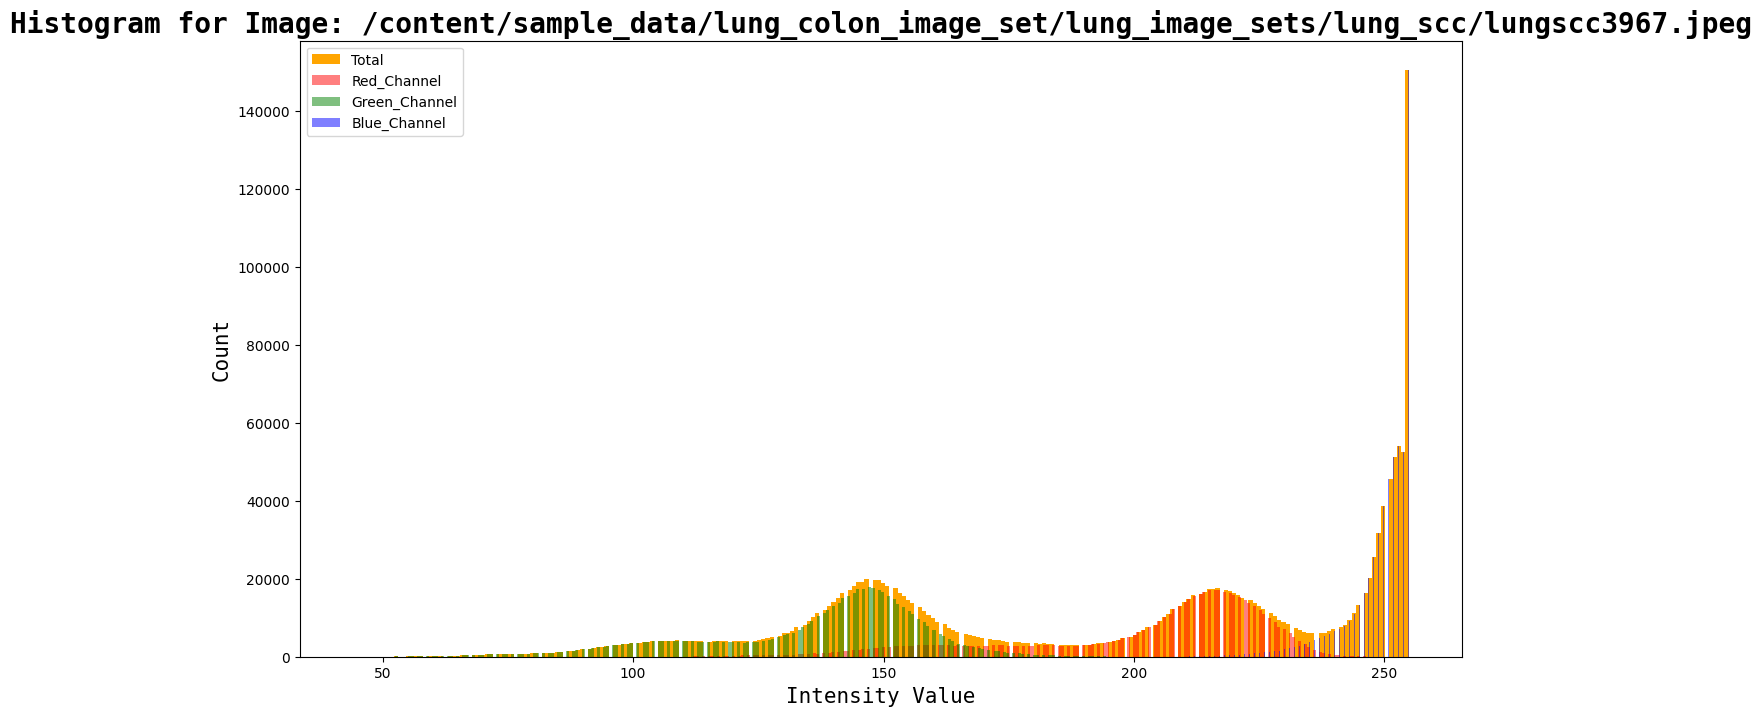

In [ ]:
# Function to plot RGB channels for random images in the dataset
def plot_random_histograms(dataframe, num_images=5, figsize=(15, 8)):
    # Select random paths from the DataFrame
    random_paths = random.sample(list(dataframe['filepaths']), num_images)

    # Plot histograms for each random image
    for image_path in random_paths:
        # Read the image
        image = io.imread(image_path)

        # Plot the histogram
        plt.figure(figsize=figsize)
        _ = plt.hist(image.ravel(), bins=256, color='orange')
        _ = plt.hist(image[:, :, 0].ravel(), bins=256, color='red', alpha=0.5)
        _ = plt.hist(image[:, :, 1].ravel(), bins=256, color='green', alpha=0.5)
        _ = plt.hist(image[:, :, 2].ravel(), bins=256, color='blue', alpha=0.5)
        _ = plt.xlabel('Intensity Value', fontdict={'fontname':'Monospace', 'fontsize': 15})
        _ = plt.ylabel('Count', fontdict={'fontname':'Monospace', 'fontsize': 15})
        _ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
        plt.title(f'Histogram for Image: {image_path}', fontdict={'fontname': 'Monospace', 'fontsize':20, 'fontweight': 'bold'})
        plt.show()

plot_random_histograms(df, num_images=4, figsize=(15, 8))

## Splitting dataset into train, test and validation

In [ ]:
# Splitting the dataset for training, testing and validation

train_split=0.8
test_split=0.1
temp_split=test_split/(1-train_split)
train_df, temp_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=42)
test_df, valid_df=train_test_split(temp_df, train_size=temp_split, shuffle=True, random_state=42)
print ('Training Data Length:', len(train_df), ' Testing Data Length:', len(test_df), ' Validation Data Length:', len(valid_df))

Training Data Length: 20000  Testing Data Length: 2500  Validation Data Length: 2500


In [ ]:
# Initializing necessary variables
height=224
width=224
channels=3
batch_size=32

# Image Shape & Size
img_shape=(height, width, channels)
img_size=(height, width)

# Calculates the largest batch size that is divisor of the length of test_df & is <= 80
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'Test Batch Size: ' ,test_batch_size, '  Test Steps: ', test_steps)

Test Batch Size:  50   Test Steps:  50


In [ ]:
def scalar(img):
  # Scale pixel between -1 and +1
  return img/127.5-1

# Image Data Generator with custom preprocessing function
gen=ImageDataGenerator(preprocessing_function=scalar)

# Creating Training Data Generator
train_gen=gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

# Creating Testing Data Generator
test_gen=gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

# Creating Validation Data Generator
valid_gen=gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

# Getting list and count of classes
classes=list(train_gen.class_indices.keys())
class_count=len(classes)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


## Displaying Sample Images

In [ ]:
# Function to display images in dataset
def display_image_samples(gen):

  # class indices from test generator
  test_dict=test_gen.class_indices

  # list of class names
  classes=list(test_dict.keys())

  # getting a sample batch from the generator
  images,labels=next(gen)
  plt.figure(figsize=(20, 20))
  length=len(labels)

  # setting number of images to be displayed
  if length<10:
    r=length
  else:
    r=10
  for i in range(r):
    plt.subplot(5, 5, i + 1)
    # scale images between 0 and 1 because pre-processor set them between -1 and +1
    image=(images[i]+1 )/2
    plt.imshow(image)
    index=np.argmax(labels[i])
    class_name=classes[index]
    plt.title(class_name, color='red', fontsize=15)
    plt.axis('off')
  plt.show()

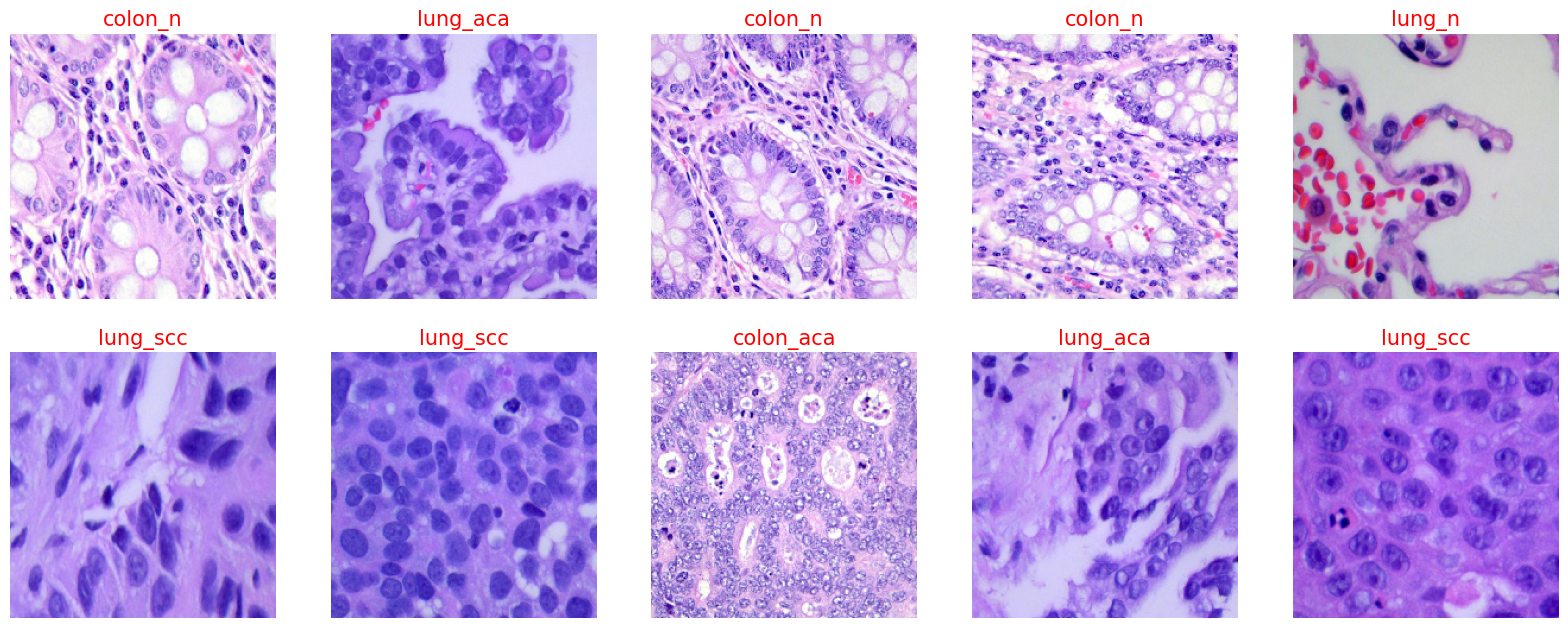

In [ ]:
display_image_samples(train_gen)

## Functions

In [ ]:
# Learning Rate Adjustment Function
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze, initial_epoch):
        # initializing the callback with various parameters
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # number of epochs to wait before stopping training if the monitored value is not improving
        self.threshold=threshold # specifies training accuracy threshold when learning rate will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell # if True and monitored metric does not improve on current epoch set modelweights back to weights of previous epoch
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        self.initial_epoch=initial_epoch
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name}'
        print(msgs)

    def on_epoch_begin(self,epoch, logs=None): # function called at the beginning of each epoch to record time
        self.now= time.time()

    def on_epoch_end(self, epoch, logs=None):  # function called at the end of each epoch
        later=time.time()
        duration=later-self.now # calculates the duration of epoch
        if epoch== self.initial_epoch or LRA.reset==True:
            LRA.reset=False
            msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^11s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy','V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
            print(msg)

        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy
        v_acc=logs.get('val_accuracy') # get the validation accuracy
        loss=logs.get('loss') # get the loss
        if acc < self.threshold: # if training accuracy is below threshold adjust learning rate based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss: # validation loss improved in the epoch
                    self.lowest_vloss=v_loss # replace loweest validation loss with new validation loss
                self.lr=lr
            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience-1:
                    self.lr= lr* self.factor # adjust the learning rate by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss
                else:
                    self.count=self.count +1 # increment patience counter
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved
                self.stop_count=0
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    self.lr=self.lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because learning rate was adjusted
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point
                else:
                    # increment the patience counter
                    self.count =self.count +1
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
                    msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
                    print(msg)
        # check if learning rate has been adjusted stop_count times with no improvement
        if self.stop_count> self.stop_patience - 1:
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            # stop training
            self.model.stop_training = True

In [ ]:
# Function to Plot Loss & Accuracy Graph
def plot_loss_acc(tr_data, start_epoch):
    # Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'b',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'purple', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'b',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'purple', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

In [ ]:
# Function to predict labels of images after training the model for Xception+MobileNet
def predict_labels(test_df, model):
    test_image_paths = test_df['filepaths'].tolist()
    true_labels = test_df['labels'].tolist()

    # Lists to store predicted labels and probabilities
    predicted_labels = []
    predicted_probabilities = []

    # Creating a label encoder and fit it on the true labels
    label_encoder = LabelEncoder()
    label_encoder.fit(true_labels)

    for test_image_path, true_label in zip(test_image_paths, true_labels):
        # Load and preprocess the test image
        img = image.load_img(test_image_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalize pixel values

        # Make predictions
        prediction = model.predict(img_array)

        # Get the predicted class label
        predicted_label_numeric = np.argmax(prediction)

        try:
            # Converting the predicted label to the original string format
            predicted_label_str = label_encoder.classes_[predicted_label_numeric]
        except IndexError:
            # Handle unknown classes by assigning a default label
            predicted_label_str = 'Unknown'

        # Appending the results to lists
        predicted_labels.append(predicted_label_str)
        predicted_probabilities.append(prediction)

    # Convert the list of predicted probabilities to a numpy array
    predicted_probabilities = np.array(predicted_probabilities)

    return predicted_labels, predicted_probabilities, true_labels

In [ ]:
# Function to plot images along with predicted and true labels for Xception+MobileNet
def plot_images_with_labels(test_df, true_labels, predicted_labels, num_images=5):
    test_image_paths = test_df['filepaths'].tolist()

    test_image_paths = test_image_paths[:num_images]
    true_labels = true_labels[:num_images]
    predicted_labels = predicted_labels[:num_images]

    num_cols = 2
    num_rows = (num_images + num_cols - 1) // num_cols

    # Creating subplots
    fig = plt.figure(figsize=(15, 7))
    gs = gridspec.GridSpec(num_rows, num_cols, width_ratios=[1, 1])

    for i, (test_image_path, true_label, predicted_label) in enumerate(zip(test_image_paths, true_labels, predicted_labels)):
        ax = plt.subplot(gs[i])
        img = image.load_img(test_image_path, target_size=(224, 224))
        plt.imshow(img)
        plt.axis('off')

        title = f'True: {true_label}\nPredicted: {predicted_label}'
        ax.set_title(title, fontsize=12)

    plt.show()

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, classes):
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh=cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [ ]:
# Function to predict labels on test data for Vision Transformer model
def predict_label_vit(test_gen, model):
    # Generate predictions using the model and the test generator
    predictions = model.predict(test_gen, steps=len(test_gen), verbose=1)

    true_labels = np.concatenate([test_gen[i][1] for i in range(len(test_gen))])

    # Convert predictions and true labels to class indices
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(true_labels, axis=1)

    return predicted_classes, true_classes

In [ ]:
# Function to plot images along with predicted and true labels for Vision Transformer Model
def plot_images_with_labels_vit(test_gen, true_labels, predicted_labels, num_images=5):
    # Extract file paths from the test generator
    test_image_paths = test_gen.filepaths[:num_images]
    true_labels = true_labels[:num_images]
    predicted_labels = predicted_labels[:num_images]

    num_cols = 2
    num_rows = (num_images + num_cols - 1) // num_cols
    fig = plt.figure(figsize=(15, 7))
    gs = gridspec.GridSpec(num_rows, num_cols, width_ratios=[1, 1])

    for i, (test_image_path, true_label, predicted_label) in enumerate(zip(test_image_paths, true_labels, predicted_labels)):
        ax = plt.subplot(gs[i])
        img = image.load_img(test_image_path, target_size=(224, 224))
        plt.imshow(img)
        plt.axis('off')

        title = f'True: {true_label}\nPredicted: {predicted_label}'
        ax.set_title(title, fontsize=12)

    plt.show()

## Implementing hybrid CNN model i.e., Xception+MobileNet

In [ ]:
# Image size and number of classes
IMG_SIZE=224
num_classes=len(classes)

# Getting pretrained weights for mobile net and xception
mobilenet = MobileNet(weights='imagenet', include_top=False)
xception = Xception(weights='imagenet', include_top=False)

# freeze the layers
for layer in mobilenet.layers:
    layer.trainable = False
for layer in xception.layers:
    layer.trainable = False

# creating a single input layer
input_layer = Input(shape=(224,224,3))

# connecting the input layer to both models
x1 = mobilenet(input_layer)
x2 = xception(input_layer)

# concatenating the outputs from both models
concatenated = Concatenate()([x1, x2])

# adding a few dense layers for the final prediction
flat = Flatten()(concatenated)
dense = Dense(units=1024, activation='relu')(flat)
dense = Dense(512, activation='relu')(dense)
dense = Dense(units=256, activation='relu')(dense)
predictions = Dense(num_classes, activation='softmax')(dense)

# compile the model
model = Model(inputs=input_layer, outputs=predictions)
model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC(), 'mae', 'mse', RootMeanSquaredError()])

# Model Summary
model.summary()

model_name='Xception+MobileNet'

# Early stopping is used to prevent overfitting and save time by stopping the training process when
# the model's performance is no longer improving in validation set
early_stop = EarlyStopping(monitor= 'val_loss', patience=15,mode = 'min' ,verbose=1)

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenet_1.00_224 (Functi  (None, None, None, 1024)     3228864   ['input_3[0][0]']             
 onal)                                                                                            
                                                                                                  
 xception (Functional)       (None, None, None, 2048)     2086148   ['input_3[0][0]']             
                                                          0                                       
                             

## Training Hybrid CNN Model; Xception+MobileNet

In [ ]:
with tf.device('/device:GPU:0'):
  # number of epochs
  epochs=15
  # number of epochs to wait to adjust learning rate if monitored value does not improve
  patience=9
  # number of epochs to wait before stopping training if monitored value does not improve
  stop_patience=3
  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
  threshold=0.9
  # factor to reduce learning rate by
  factor=0.5
  # if True and monitored metric does not improve on current epoch set modelweights back to weights of previous epoch
  dwell=True
  # if true free weights of the base model
  freeze=False

  callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                    factor=factor,dwell=dwell,model_name= model_name,  freeze=freeze, initial_epoch=0 )]
  LRA.tepochs=epochs
  history=model.fit(x=train_gen,  epochs=epochs, callbacks=callbacks, verbose=1,  validation_data=valid_gen,validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model Xception+MobileNet
Epoch 1/15
625/625 [==============================] - 139s 222ms/step - loss: 0.1089 - accuracy: 0.9732 - precision: 0.9732 - recall: 0.9731 - auc: 0.9956 - mae: 0.0119 - mse: 0.0087 - root_mean_squared_error: 0.0934 - val_loss: 0.1992 - val_accuracy: 0.9392 - val_precision: 0.9392 - val_recall: 0.9392 - val_auc: 0.9919 - val_mae: 0.0250 - val_mse: 0.0194 - val_root_mean_squared_error: 0.1394
Epoch 2/15
625/625 [==============================] - 137s 219ms/step - loss: 0.0708 - accuracy: 0.9830 - precision: 0.9830 - recall: 0.9829 - auc: 0.9975 - mae: 0.0079 - mse: 0.0056 - root_mean_squared_error: 0.0749 - val_loss: 0.0315 - val_accuracy: 0.9908 - val_precision: 0.9908 - val_recall: 0.9908 - val_auc: 0.9992 - val_mae: 0.0047 - val_mse: 0.0030 - val_root_mean_squared_error: 0.0546
Epoch 3/15
625/625 [==============================] - 137s 218ms/step - loss: 0.0303 - accuracy: 0.9930 - precision: 0.9930 - recall: 0.9930 - auc: 0.999

## Plotting Loss & Accuracy Graph for Xception+MobileNet

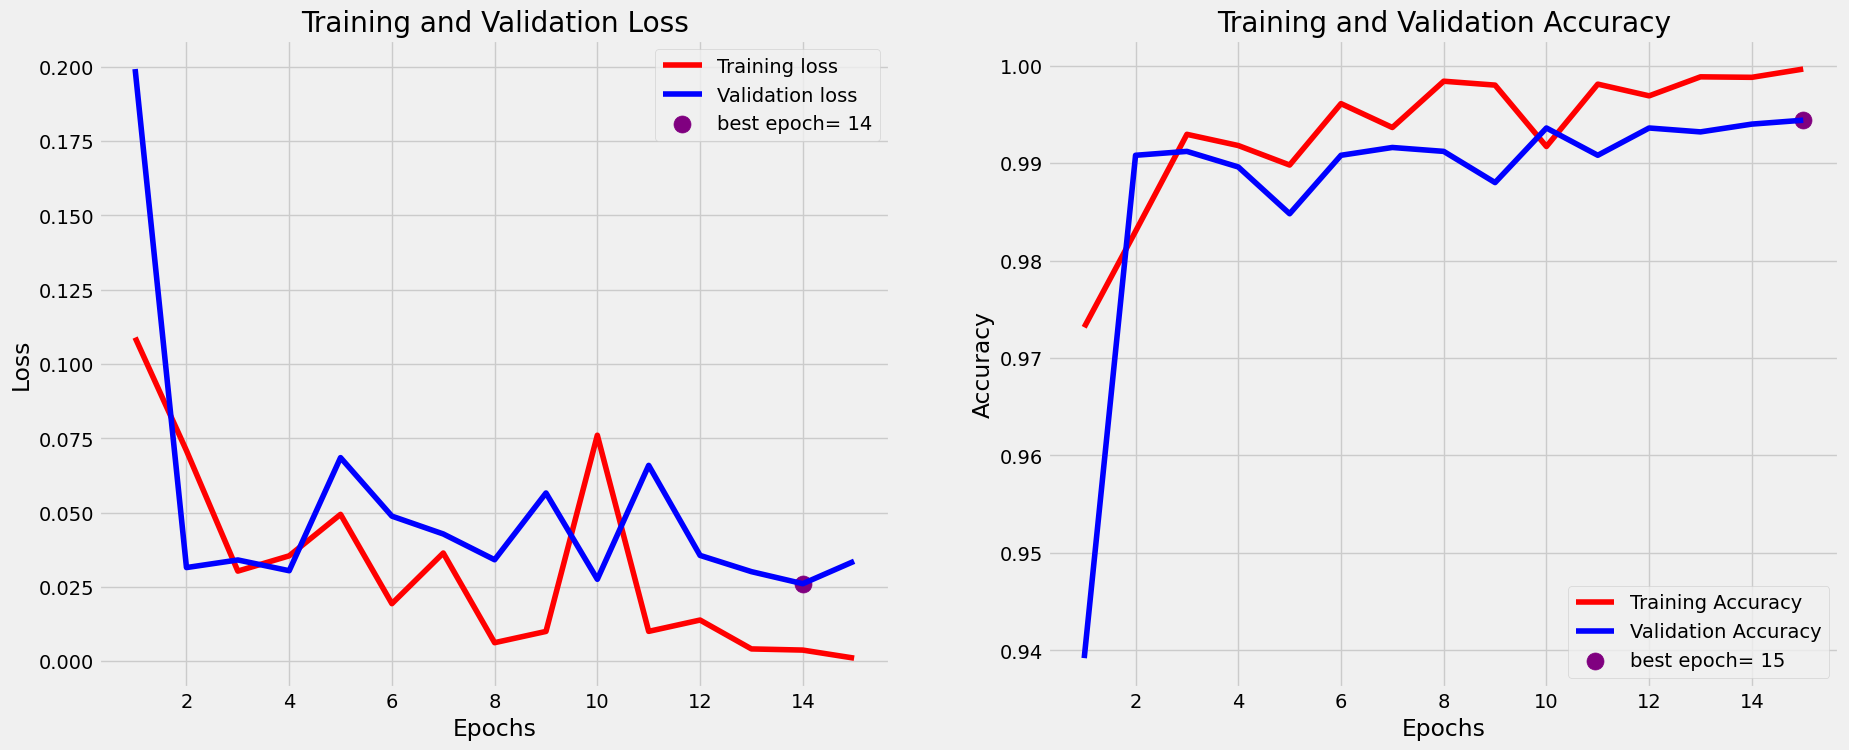

In [ ]:
plot_loss_acc(history,0)

## Xception+MobileNet Model Prediction

In [ ]:
predicted_labels, predicted_probabilities, true_labels=predict_labels(test_df, model)

1/1 [==============================] - 0s 39ms/step


## Classification Report

In [ ]:
# Evaluating the accuracy of Xception+MobileNet on the entire test set
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Test Accuracy on Test Set: {accuracy}')
print(classification_report(true_labels, predicted_labels, zero_division=1))

Test Accuracy on Test Set: 0.9856
              precision    recall  f1-score   support

   colon_aca       0.99      1.00      0.99       504
     colon_n       1.00      1.00      1.00       514
    lung_aca       0.97      0.96      0.97       503
      lung_n       1.00      0.99      0.99       491
    lung_scc       0.97      0.98      0.97       488

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



## Displaying Images with True & Predicted Labels for Hybrid CNN Model (Xception+MobileNet)

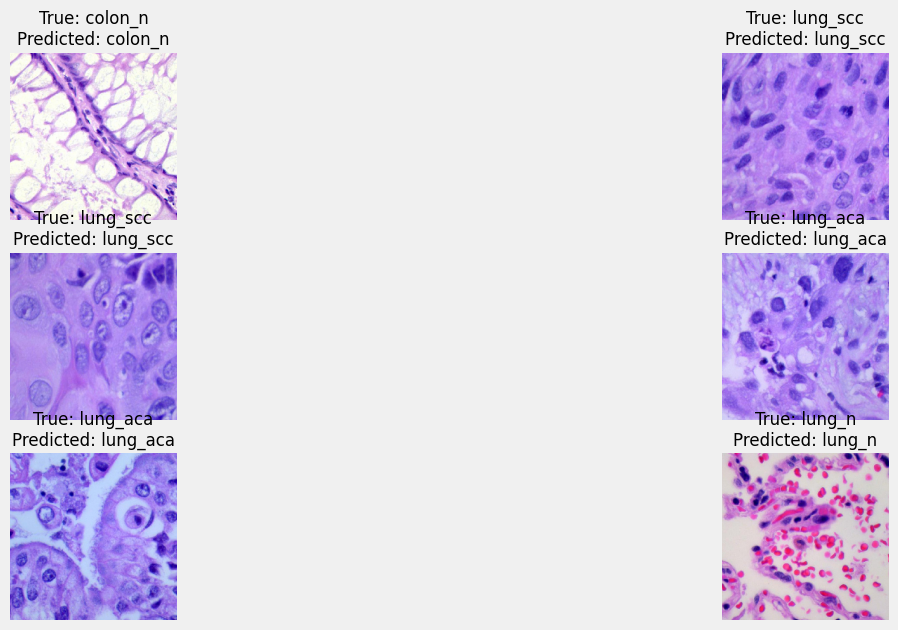

In [ ]:
plot_images_with_labels(test_df, true_labels, predicted_labels, num_images=6)

## Plotting Confusion Matrix

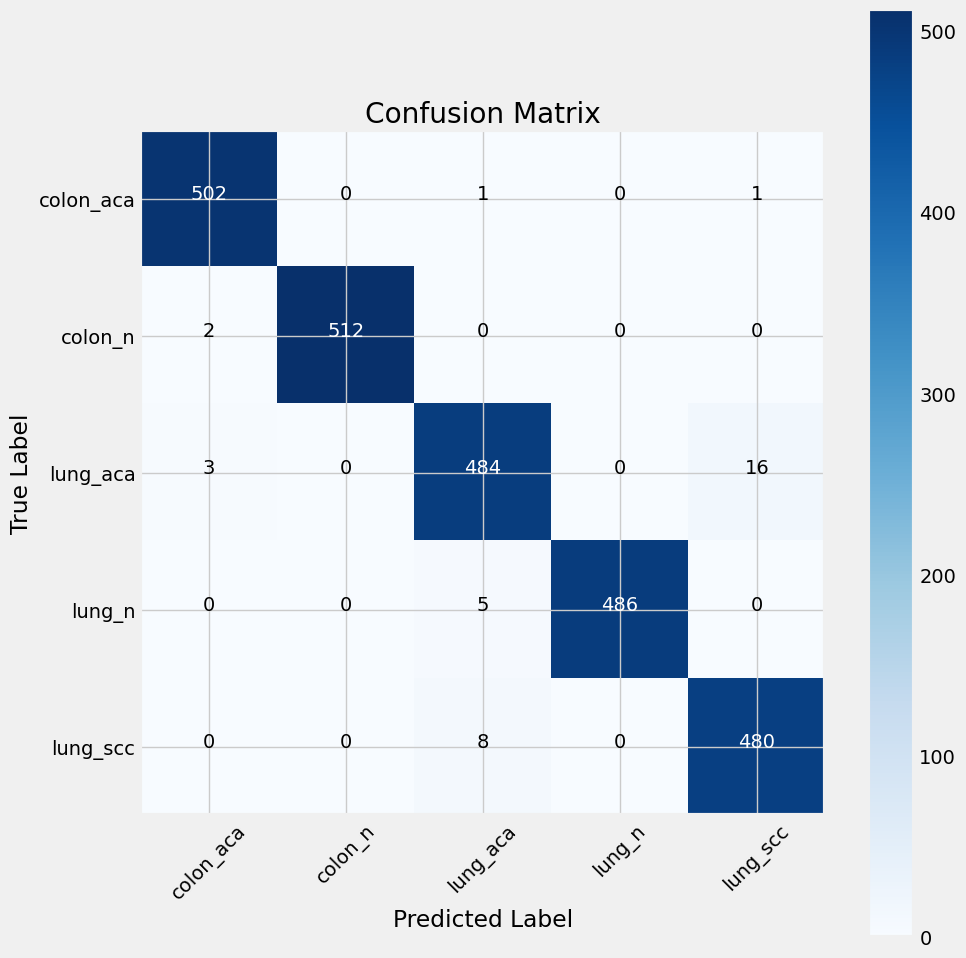

In [ ]:
plot_confusion_matrix(true_labels, predicted_labels, classes)

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.0 MB/s eta 0:00:00


## Implementing Vision Transformer

In [ ]:
def create_vit_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Patch Embedding
    patch_size = 16
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = layers.Conv2D(64, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
    x = layers.Reshape((num_patches, 64))(x)

    # Multi-Head Self Attention
    attention_output = layers.MultiHeadAttention(
        num_heads=8, key_dim=64, dropout=0.1
    )(x, x)

    # Add and Norm
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Feedforward Layer (MLP Block)
    mlp_output = layers.Dense(256, activation="relu")(x)
    mlp_output = layers.Dense(64, activation="relu")(mlp_output)

    # Add and Norm
    x = layers.Add()([x, mlp_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Dense Layers
    x = layers.Dense(256, activation="relu")(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.models.Model(inputs=inputs, outputs=outputs)

    return model

img_shape = (224, 224, 3)
num_classes = 5
vit_model = create_vit_model(img_shape, num_classes)

vit_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

vit_model.summary()

# Early stopping is used ti prevent overfitting and save time by stopping the training process when
# the model's performance is no longer improving in validation set
early_stop = EarlyStopping(monitor= 'val_loss', patience=15,mode = 'min' ,verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 64)           49216     ['input_1[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 196, 64)              0         ['conv2d[0][0]']              
                                                                                                  
 multi_head_attention (Mult  (None, 196, 64)              132672    ['reshape[0][0]',             
 iHeadAttention)                                                     'reshape[0][0]']         

## Training ViT Model

In [ ]:
# Training ViT
with tf.device('/device:GPU:0'):
  epochs=100
  # number of epochs to wait to adjust learning rate if monitored value does not improve
  patience=9
  # number of epochs to wait before stopping training if monitored value does not improve
  stop_patience=3
  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
  threshold=0.9
  # factor to reduce learning rate by
  factor=0.5
  #if True and monitored metric does not improve on current epoch set modelweights back to weights of previous epoch
  dwell=True
  # if true free weights of the base model
  freeze=False
  callbacks_vit=[LRA(model=vit_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
            factor=factor,dwell=dwell,model_name= "Vision Transformer",  freeze=freeze, initial_epoch=0 )]
  LRA.tepochs=epochs
  history_vit = vit_model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=callbacks_vit)

 Starting training using base model Vision Transformer
Epoch 1/100
625/625 [==============================] - 119s 165ms/step - loss: 0.4136 - accuracy: 0.8243 - val_loss: 0.3158 - val_accuracy: 0.8640
Epoch 2/100
625/625 [==============================] - 107s 171ms/step - loss: 0.2480 - accuracy: 0.8979 - val_loss: 0.2000 - val_accuracy: 0.9144
Epoch 3/100
625/625 [==============================] - 103s 164ms/step - loss: 0.1967 - accuracy: 0.9195 - val_loss: 0.1682 - val_accuracy: 0.9384
Epoch 4/100
625/625 [==============================] - 101s 162ms/step - loss: 0.1828 - accuracy: 0.9266 - val_loss: 0.1773 - val_accuracy: 0.9380
Epoch 5/100
625/625 [==============================] - 100s 160ms/step - loss: 0.1625 - accuracy: 0.9356 - val_loss: 0.1907 - val_accuracy: 0.9216
Epoch 6/100
625/625 [==============================] - 113s 181ms/step - loss: 0.1521 - accuracy: 0.9387 - val_loss: 0.1626 - val_accuracy: 0.9380
Epoch 7/100
625/625 [==============================] - 101s 162

## Plotting Loss & Accuracy Graph for ViT

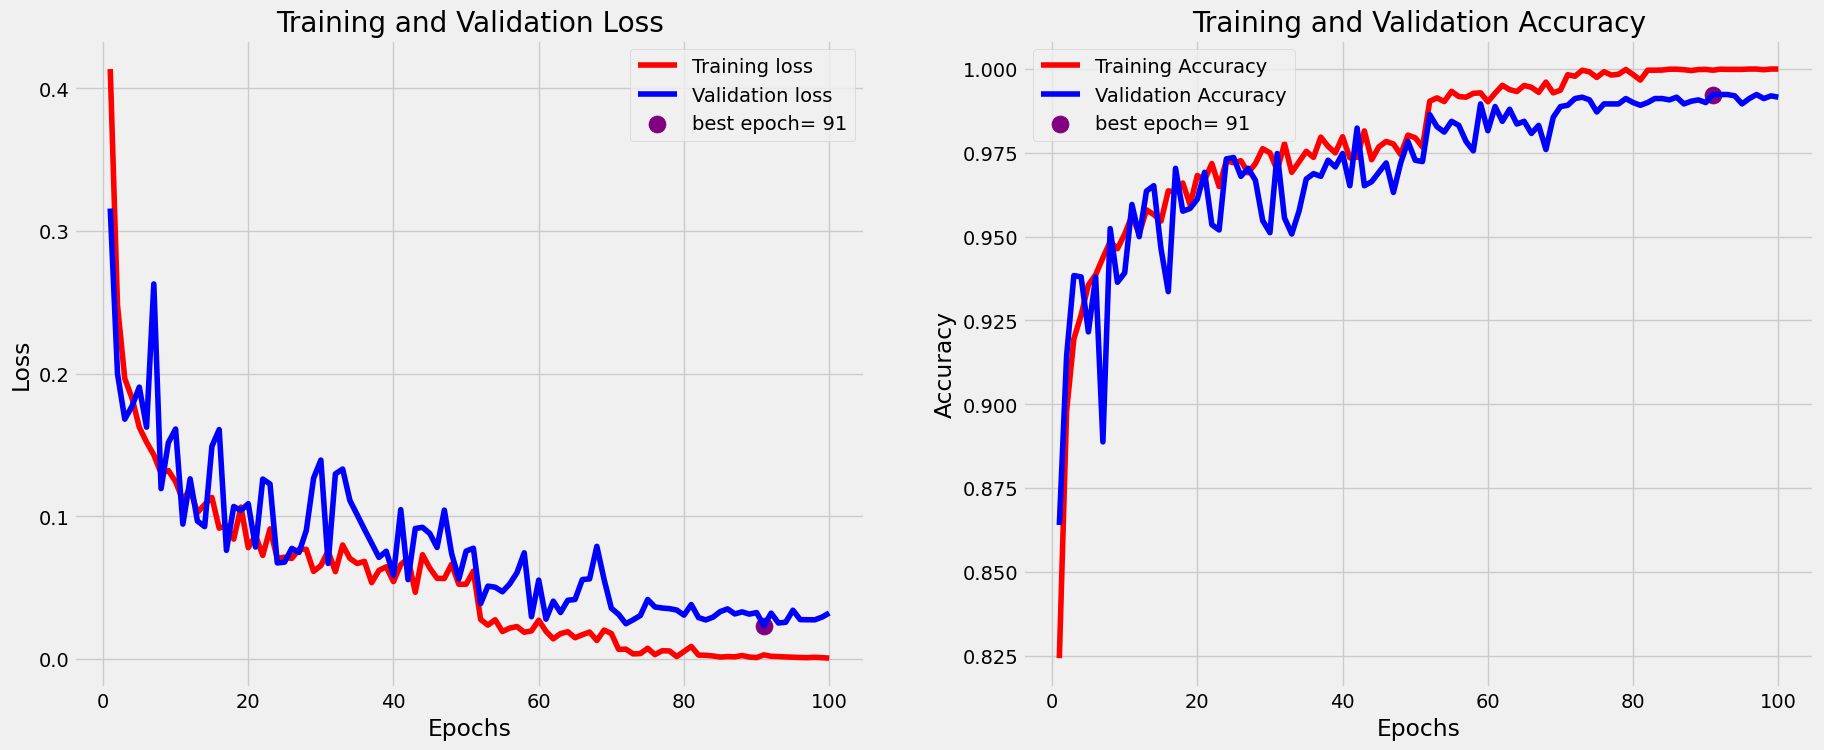

In [ ]:
plot_loss_acc(history_vit,0)

## ViT Model Prediction

In [ ]:
predicted_labels_vit, true_labels_vit = predict_label_vit(test_gen, vit_model)

50/50 [==============================] - 15s 295ms/step


## Classification Report

In [ ]:
# Evaluating the accuracy of Vision Transformer on the entire test set
accuracy = accuracy_score(true_labels_vit, predicted_labels_vit)
print(f'Test Accuracy on Test Set: {accuracy}')
print(classification_report(true_labels_vit, predicted_labels_vit, zero_division=1))

Test Accuracy on Test Set: 0.9884
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       504
           1       0.99      0.99      0.99       514
           2       0.98      0.98      0.98       503
           3       1.00      1.00      1.00       491
           4       0.98      0.98      0.98       488

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



## Displaying Images with True & Predicted Labels for ViT Model

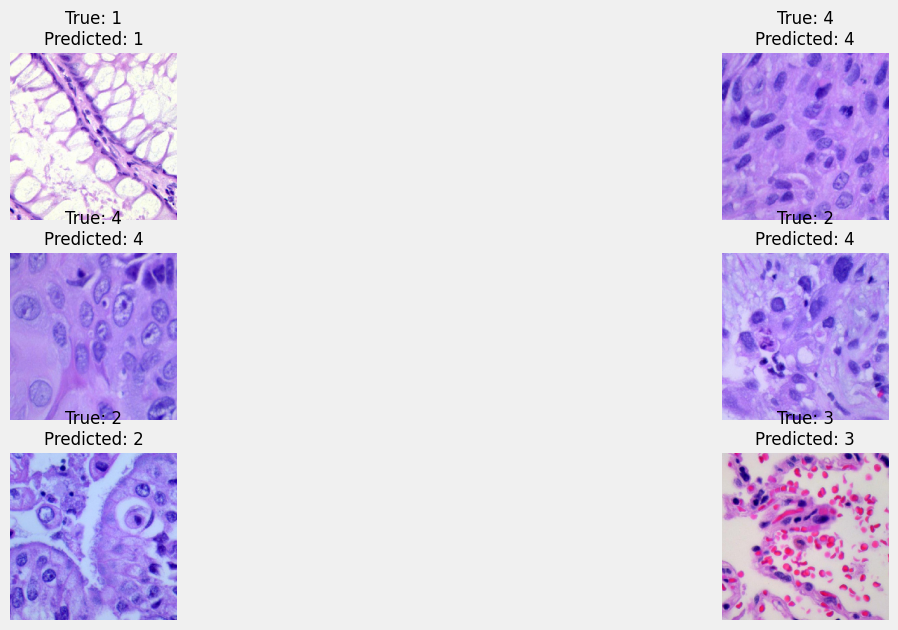

In [ ]:
plot_images_with_labels_vit(test_gen, true_labels_vit, predicted_labels_vit, num_images=6)

## Plotting Confusion Matrix

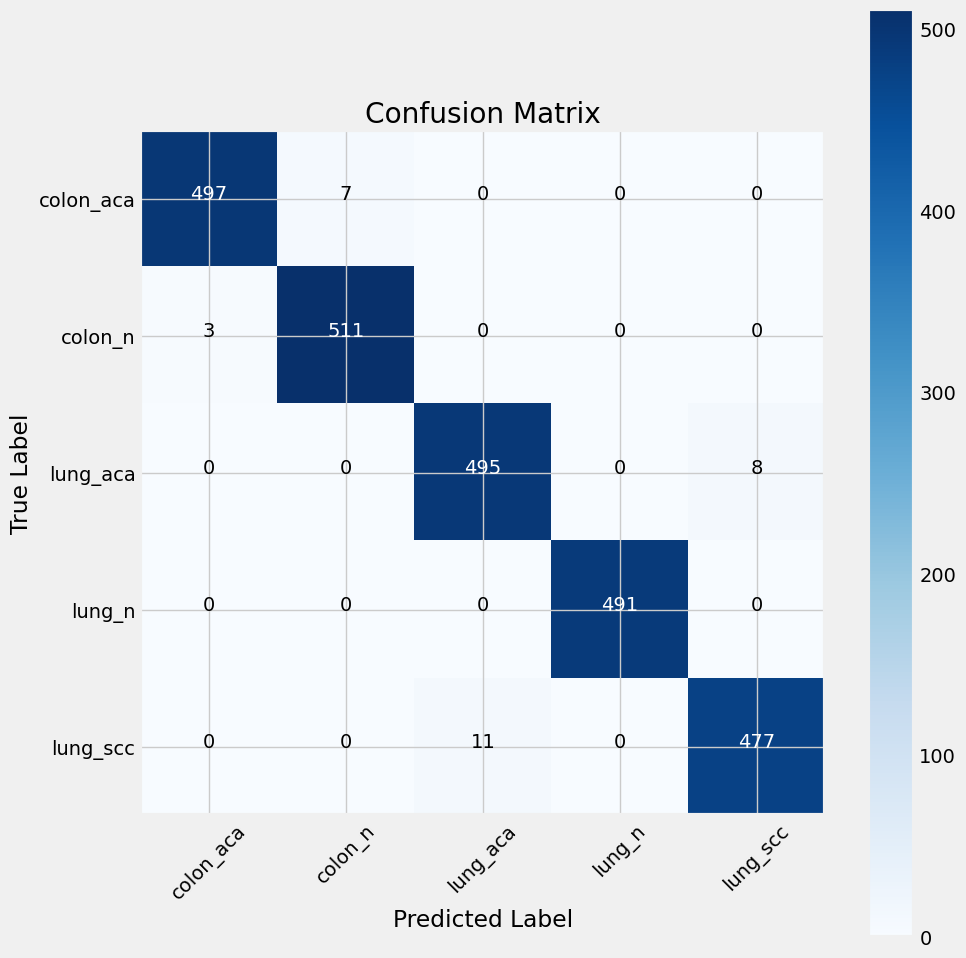

In [ ]:
# Generating Confusion Matrix for ViT
plot_confusion_matrix(true_labels_vit, predicted_labels_vit, classes)

## Saving Model & Weights

In [ ]:
# Saving model and weights
vit_model.save("/content/drive/MyDrive/vit_model.h5")
model.save("/content/drive/MyDrive/cnn_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save_weights("/content/drive/MyDrive/cnn_model_weights.h5")
vit_model.save_weights("/content/drive/MyDrive/vit_model_weights.h5")

In [ ]:
cnn_model = load_model('/content/drive/MyDrive/cnn_model.h5')

In [ ]:
vit_model = load_model('/content/drive/MyDrive/vit_model.h5')